In [25]:
import sys
import pandas as pd
import numpy as np

from utils import pre_all
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [26]:
print(f"파이썬 버전 : {sys.version}")
print(f"pandas 버전 : {pd.__version__}")
print(f"numpy 버전 : {np.__version__}")

파이썬 버전 : 3.10.14 | packaged by conda-forge | (main, Mar 20 2024, 12:45:18) [GCC 12.3.0]
pandas 버전 : 2.1.4
numpy 버전 : 1.26.4


In [27]:
train_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/train.csv')[['ID','timestamp','supply(kg)', 'price(원/kg)']]
test_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/test.csv')[['ID','timestamp']]
# train_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/train.csv')
# test_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/test.csv')

In [28]:
train_df['item_id'] = train_df.ID.str[0:6]
test_df['item_id'] = test_df.ID.str[0:6]

In [29]:
# train, test = pre_all(train_df, test_df)

전처리 전 train 크기 : (59397, 8)
전처리 전 test 크기 : (1092, 6)
=================전처리 중=================
전처리 후 train 크기 : (59397, 16)
전처리 후 test 크기 : (1092, 16)


In [30]:
# make static_features_df
static_features_df = train.loc[:, ['item_id', 'item', 'corporation', 'location']]
static_features_df = static_features_df.drop_duplicates()
print(static_features_df.head())

  item_id item corporation location
0  TG_A_J   TG           A        J
1  CB_A_S   CB           A        S
2  RD_D_J   RD           D        J
3  BC_D_J   BC           D        J
4  CB_F_J   CB           F        J


In [31]:
train.drop(columns=['ID', 'item', 'corporation', 'location'], inplace=True)
test.drop(columns=['ID'], inplace=True)

In [32]:
print(train.head())
print(test.head())

   timestamp  supply  price item_id  year  month  day  week_day  year_month  \
0 2019-01-01     0.0    0.0  TG_A_J  2019      1    1         1           0   
1 2019-01-01     0.0    0.0  CB_A_S  2019      1    1         1           0   
2 2019-01-01     0.0    0.0  RD_D_J  2019      1    1         1           0   
3 2019-01-01     0.0    0.0  BC_D_J  2019      1    1         1           0   
4 2019-01-01     0.0    0.0  CB_F_J  2019      1    1         1           0   

   week  week_num  holiday  
0     1         1        1  
1     1         1        1  
2     1         1        1  
3     1         1        1  
4     1         1        1  
   timestamp item corporation location  supply  price item_id  year  month  \
0 2023-03-04   TG           A        J     NaN    NaN  TG_A_J  2023      3   
1 2023-03-04   TG           E        S     NaN    NaN  TG_E_S  2023      3   
2 2023-03-04   BC           B        J     NaN    NaN  BC_B_J  2023      3   
3 2023-03-04   TG           E        J 

In [33]:
# train_df = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/train.csv')[['ID','timestamp','supply(kg)', 'price(원/kg)']]
# train_df['item_id'] = train_df.ID.str[0:6]
# data = TimeSeriesDataFrame(train_df.drop(columns=['ID']))
# print(data.head())

In [34]:
train_data = TimeSeriesDataFrame.from_data_frame(
    train,
    id_column="item_id",
    # timestamp_column="timestamp",
    # static_features_df=static_features_df,
)
print(train_data.head())
print(train_data.static_features.head())

                    supply  price  year  month  day  week_day  year_month  \
item_id timestamp                                                           
TG_A_J  2019-01-01     0.0    0.0  2019      1    1         1           0   
CB_A_S  2019-01-01     0.0    0.0  2019      1    1         1           0   
RD_D_J  2019-01-01     0.0    0.0  2019      1    1         1           0   
BC_D_J  2019-01-01     0.0    0.0  2019      1    1         1           0   
CB_F_J  2019-01-01     0.0    0.0  2019      1    1         1           0   

                    week  week_num  holiday  
item_id timestamp                            
TG_A_J  2019-01-01     1         1        1  
CB_A_S  2019-01-01     1         1        1  
RD_D_J  2019-01-01     1         1        1  
BC_D_J  2019-01-01     1         1        1  
CB_F_J  2019-01-01     1         1        1  
        item corporation location
item_id                          
TG_A_J    TG           A        J
CB_A_S    CB           A        S
RD

In [35]:
# # create own validation set (march 4~31 of 2019, 2020, 2021, 2022)
# march_2019_threshold = pd.to_datetime('2019-03-31')
# val_set_1 = train_data[train_data.index.get_level_values('timestamp') <= march_2019_threshold]

# march_2020_threshold = pd.to_datetime('2020-03-31')
# val_set_2 = train_data[(train_data.index.get_level_values('timestamp') > march_2019_threshold) & (train_data.index.get_level_values('timestamp') <= march_2020_threshold)]

# march_2021_threshold = pd.to_datetime('2021-03-31')
# val_set_3 = train_data[(train_data.index.get_level_values('timestamp') > march_2020_threshold) & (train_data.index.get_level_values('timestamp') <= march_2021_threshold)]

# march_2022_threshold = pd.to_datetime('2022-03-31')
# val_set_4 = train_data[(train_data.index.get_level_values('timestamp') > march_2021_threshold) & (train_data.index.get_level_values('timestamp') <= march_2022_threshold)]

# my_validation_dataset = pd.concat([val_set_1, val_set_2, val_set_3, val_set_4], axis=0)
# my_validation_dataset


In [54]:
known_covariates = ["year", "month", "day", "week_day", "year_month", "week", "week_num", "holiday"]

# configure target and known, past covariates in predictor
predictor = TimeSeriesPredictor( 
    prediction_length=28,
    target="price",
    # known_covariates_names=known_covariates, # supply and x_prev_price columns will automatically interpreted as past covariates
    eval_metric="RMSE",
)

# seed 고정
predictor.fit(train_data,
            #   presets="high_quality",
              # presets="best_quality",
              random_seed=42,
              # tuning_data=my_validation_dataset,
              # num_val_windows=3,
              hyperparameters={
                "DLinear": {},
                "PatchTST": [
                    {"context_length": 365}, # default 96 (look-back window length)
                    {"num_encoder_layers": 6},
                ],
                "DeepAR": {},
                "Theta": [
                    {"decomposition_type": "additive"},
                    {"seasonal_period": 1},
                ],
            }
        )

No path specified. Models will be saved in: "AutogluonModels/ag-20240328_143544"
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels/ag-20240328_143544'
=================== System Info ===================
AutoGluon Version:  1.0.0
Python Version:     3.10.14
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Thu Jan 11 04:09:03 UTC 2024
CPU Count:          16
GPU Count:          0
Memory Avail:       9.47 GB / 15.20 GB (62.3%)
Disk Space Avail:   905.43 GB / 1006.85 GB (89.9%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'hyperparameters': {'DLinear': {},
                     'DeepAR': {},
                     'PatchTST': [{'context_length': 365},
                                  {'num_encoder_layers': 6}],
                     'Theta': [{'decomposition_type': 'additive'},
                               {'seasonal_period': 1}]},
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length

In [55]:
predictor.refit_full()

Refitting models via `refit_full` using all of the data (combined train and validation)...
	Models trained in this way will have the suffix '_FULL' and have NaN validation score.
	This process is not bound by time_limit, but should take less time than the original `fit` call.
Fitting model: Theta_FULL | Skipping fit via cloning parent ...
Fitting model: Theta_2_FULL | Skipping fit via cloning parent ...
Fitting model: WeightedEnsemble_FULL | Skipping fit via cloning parent ...
Refit complete. Models trained: ['Theta_FULL', 'Theta_2_FULL', 'WeightedEnsemble_FULL']
Total runtime: 0.01 s
Updated best model to 'WeightedEnsemble_FULL' (Previously 'WeightedEnsemble'). AutoGluon will default to using 'WeightedEnsemble_FULL' for predict().


{'Theta': 'Theta_FULL',
 'Theta_2': 'Theta_2_FULL',
 'WeightedEnsemble': 'WeightedEnsemble_FULL'}

In [56]:
test_data = TimeSeriesDataFrame.from_data_frame(
    test,
    id_column="item_id",
    timestamp_column="timestamp",
    # static_features_df=static_features_df,
)

In [57]:
train_data.iloc[:, :10]

,,supply,price,year,month,day,week_day,year_month,week,week_num,holiday
item_id,timestamp,,,,,,,,,,
TG_A_J,2019-01-01,0.0,0.0,2019,1,1,1,0,1,1,1
CB_A_S,2019-01-01,0.0,0.0,2019,1,1,1,0,1,1,1
RD_D_J,2019-01-01,0.0,0.0,2019,1,1,1,0,1,1,1
BC_D_J,2019-01-01,0.0,0.0,2019,1,1,1,0,1,1,1
CB_F_J,2019-01-01,0.0,0.0,2019,1,1,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
CR_E_S,2023-03-03,0.0,0.0,2023,3,3,4,50,9,219,0
BC_A_S,2023-03-03,3776.0,2875.0,2023,3,3,4,50,9,219,0
CB_E_J,2023-03-03,0.0,0.0,2023,3,3,4,50,9,219,0


In [40]:
test_data.drop(columns=["item", "corporation", "location", "supply", "price"])

,,year,month,day,week_day,year_month,week,week_num,holiday
item_id,timestamp,,,,,,,,
TG_A_J,2023-03-04,2023,3,4,5,50,9,219,0
TG_E_S,2023-03-04,2023,3,4,5,50,9,219,0
BC_B_J,2023-03-04,2023,3,4,5,50,9,219,0
TG_E_J,2023-03-04,2023,3,4,5,50,9,219,0
BC_B_S,2023-03-04,2023,3,4,5,50,9,219,0
...,...,...,...,...,...,...,...,...,...
TG_A_J,2023-03-31,2023,3,31,4,50,13,223,0
RD_D_J,2023-03-31,2023,3,31,4,50,13,223,0
CR_D_J,2023-03-31,2023,3,31,4,50,13,223,0


In [41]:
pred_data = pd.concat([train_data.iloc[:, :10], test_data.drop(columns=["item", "corporation", "location", "supply", "price"])], axis=0)

In [42]:
test_data['year']

item_id  timestamp 
TG_A_J   2023-03-04    2023
TG_E_S   2023-03-04    2023
BC_B_J   2023-03-04    2023
TG_E_J   2023-03-04    2023
BC_B_S   2023-03-04    2023
                       ... 
TG_A_J   2023-03-31    2023
RD_D_J   2023-03-31    2023
CR_D_J   2023-03-31    2023
TG_E_J   2023-03-31    2023
RD_F_J   2023-03-31    2023
Name: year, Length: 1092, dtype: int32

In [43]:
from autogluon.timeseries.utils.forecast import get_forecast_horizon_index_ts_dataframe

future_index = get_forecast_horizon_index_ts_dataframe(train_data, prediction_length=28)
future_timestamps = future_index.get_level_values("timestamp")
known_covariates_pred_df = pd.DataFrame(index=future_index)
for kc in known_covariates:
    known_covariates_pred_df[kc] = test_data[kc]
known_covariates_pred_df.head()

year  month  day  week_day  year_month  week  week_num  \
item_id timestamp                                                            
TG_A_J  2023-03-04  2023      3    4         5          50     9       219   
        2023-03-05  2023      3    5         6          50     9       219   
        2023-03-06  2023      3    6         0          50    10       220   
        2023-03-07  2023      3    7         1          50    10       220   
        2023-03-08  2023      3    8         2          50    10       220   

                    holiday  
item_id timestamp            
TG_A_J  2023-03-04        0  
        2023-03-05        0  
        2023-03-06        0  
        2023-03-07        0  
        2023-03-08        0

In [59]:
# seed 고정
pred = predictor.predict(train_data,
                        #  known_covariates=known_covariates_pred_df,
                         random_seed=42,
                         )
pred

Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble_FULL


mean          0.1          0.2          0.3  \
item_id timestamp                                                        
TG_A_J  2023-03-04  2458.114449  -508.622355   370.082592  1017.554356   
        2023-03-05   332.139631 -2946.653212 -1856.283969 -1086.565428   
        2023-03-06  2901.501393  -773.316333   646.597478  1488.124006   
        2023-03-07  2803.453443  -648.582699   517.979227  1205.105932   
        2023-03-08  2799.611873    76.727215   925.396778  1691.309147   
...                         ...          ...          ...          ...   
CR_D_S  2023-03-27     0.774066  -136.470719   -89.852105   -58.110850   
        2023-03-28     0.468971  -142.973354   -89.735111   -44.727025   
        2023-03-29    -5.518765  -165.485796  -108.898221   -78.532527   
        2023-03-30    13.066329  -110.378664   -64.817387   -39.678328   
        2023-03-31    -2.027004  -150.115045  -104.659786   -63.740010   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
TG_A_J  2023-03-04  1889.996945  2589.146152  3339.614531  4007.815640   
        2023-03-05  -536.951723  -103.185437   609.160244  1244.210913   
        2023-03-06  2229.629811  2785.903857  3232.770773  3942.869996   
        2023-03-07  1843.720291  2373.542076  3089.723269  3684.569015   
        2023-03-08  2225.470905  2691.811368  3148.132523  3841.132624   
...                         ...          ...          ...          ...   
CR_D_S  2023-03-27   -29.635265    -5.436667    21.054944    52.784031   
        2023-03-28    -0.490295    21.202194    38.376597    56.342944   
        2023-03-29   -50.294862   -19.177895    15.057924    42.519654   
        2023-03-30   -18.596265     9.884077    40.148792    62.948818   
        2023-03-31   -39.902912    -3.703129    18.027218    48.621832   

                            0.8          0.9  
item_id timestamp                             
TG_A_J  2023-03-04  4750.671838  6059.772060  
        2023-03-05  1955.211410  2836.772499  
        2023-03-06  4690.384660  5764.685647  
        2023-03-07  4283.715362  5440.308355  
        2023-03-08  4831.010583  5987.776410  
...                         ...          ...  
CR_D_S  2023-03-27    89.813064   131.542591  
        2023-03-28    93.188832   136.110430  
        2023-03-29    77.135305   134.083642  
        2023-03-30    99.622218   137.826189  
        2023-03-31    75.545712   126.486231  

[1092 rows x 10 columns]

In [60]:
# # The test score is computed using the last
# # prediction_length=48 timesteps of each time series in test_data
# predictor.leaderboard(test_data)
predictor.leaderboard(train_data)

Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble_FULL,-829.751671,NaN,8.192982,NaN,0.114259,6
1,WeightedEnsemble,-829.751671,-829.751671,8.038819,30.844995,0.114259,3
2,Theta_FULL,-838.834688,NaN,2.669901,NaN,0.000341,4
3,Theta,-838.834688,-838.834688,2.639806,25.262831,0.022793,1
4,Theta_2_FULL,-1016.030941,NaN,5.522530,NaN,0.000223,5
5,Theta_2,-1016.030941,-1016.030941,5.398239,5.582164,0.024067,2


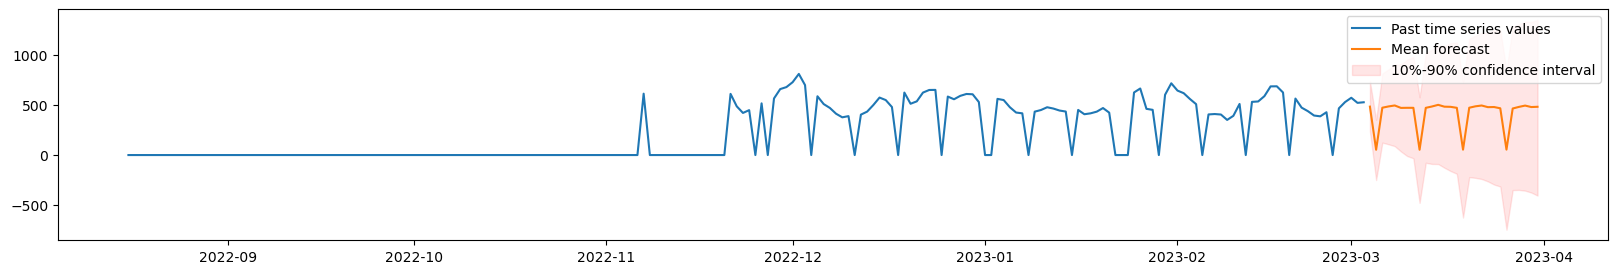

In [46]:
import matplotlib.pyplot as plt

# TimeSeriesDataFrame can also be loaded directly from a file
# test_data = TimeSeriesDataFrame.from_path("https://autogluon.s3.amazonaws.com/datasets/timeseries/m4_hourly_subset/test.csv")

plt.figure(figsize=(20, 3))

# item_id = "H1"
# item_id = "TG_A_J"
item_id = "RD_F_J"
y_past = train_data.loc[item_id]["price"]
y_pred = pred.loc[item_id]
# y_test = test_data.loc[item_id]["price(원/kg)"][-48:]

plt.plot(y_past[-200:], label="Past time series values")
plt.plot(y_pred["mean"], label="Mean forecast")
# plt.plot(y_test, label="Future time series values")

plt.fill_between(
    y_pred.index, y_pred["0.1"], y_pred["0.9"], color="red", alpha=0.1, label=f"10%-90% confidence interval"
)
plt.legend();

In [47]:
submission = pd.read_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/sample_submission.csv')
submission['answer'] = pred.reset_index()['mean']
submission.loc[ submission['answer'] < 0.0, 'answer'] = 0.0
submission.to_csv('/mnt/c/Users/wschu/OneDrive/Documents/data/jeju_specialty/open/dacon_submission.csv', index=False)
submission

,ID,answer
0,TG_A_J_20230304,3506.260490
1,TG_A_J_20230305,326.642923
2,TG_A_J_20230306,3235.870909
3,TG_A_J_20230307,2840.740199
4,TG_A_J_20230308,3384.964141
...,...,...
1087,RD_F_J_20230327,6.410059
1088,RD_F_J_20230328,5.771493
1089,RD_F_J_20230329,5.013887
1090,RD_F_J_20230330,6.964249
